In [15]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import f1_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [16]:
class BinaryClassification:
    def __init__(self, df, target):
        self.df = df.copy()
        self.target_label = target
        self.target = np.array(df[target])
    
    def preprocess_drop(self, ignore_list=[]):
        """Takes a list of columns the user wants to drop from
        from the dataframe before fitting the model. This will
        automatically include the target.

        Args:
            ignore_list (list): list of column names as strings to be removed from dataset
        Returns:
            None: dataframe copy is modified in place
        """
        # append the target to list of columsn to remove
        ignore_list.append(self.target_label)
        
        # drop each column in ignore_list on the y-axis, modified in-place
        self.df.drop(columns=ignore_list,axis=1,inplace=True)
    
    
    def preprocess_encode(self):
        """Uses sklearn LabelEncode to convert categorical data to numeric
            for use in model. 
            
        Return:
            None : encoding done in place on DataFrame
        """
        # Initialize label encoder object
        label_encode = preprocessing.LabelEncoder()
        
        # Loop across each column in the dataset
        for col in self.df.columns:
            # Check that column data is not int64 or float64, not necessary to encode 
            if self.df.dtypes[col] != 'int64' and self.df.dtypes[col] != 'float64':
                # Encode all categorical data for use in model
                self.df[col] = label_encode.fit_transform(self.df[col])
        
        # self.df = pd.get_dummies(self.df)       
    
    def preprocess_split(self):
        """Takes input dataframe and target array and splits
            into training and validation data using train_test_split
            from sklearn. Function takes no input, and generates the
            split data sets for training and testing.
        
        Return:
            None: generates train/valid datasets in place on class
        """
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.df,self.target,
                                                                                    train_size=0.7,
                                                                                    test_size=0.3,
                                                                                    random_state=0)
    
    def preprocess_impute(self):
        """Uses sklearn SimpleImputer() to fill in
            null data. Should be used on predictor dataset
            after being split by train_test_split.
            
        Return:
            None: training and validation predictors imputed in place
        """
        # Create imputer instance
        dataImpute = SimpleImputer()
        
        # Run imputer on training dataset, and transform on validation dataset
        self.X_train_imputed = pd.DataFrame(dataImpute.fit_transform(self.X_train))
        self.X_valid_imputed = pd.DataFrame(dataImpute.transform(self.X_valid))
        
        # Add columns back in that are removed in SimpleImputer
        self.X_train_imputed.columns = self.X_train.columns
        self.X_valid_imputed.columns = self.X_valid.columns
    

    def preprocess(self, ignore_list=[]):
        """Serves as a wrapper for all preprocessing methods. Calls
            preprocessing steps in correct order for model preparation.
            Performs the following:
                1. preprocess_drop: removes columns you don't want to use in the model, removes target
                2. preprocess_encode: convert categorical data into numeric for impute and modeling
                3. preprocess_split: splits dataset into training and validation data
                4. preprocess_impute: impute predictor datasets

        Args:
            ignore_list (list, optional): _description_. Defaults to [].
        """
        self.preprocess_drop(params_to_ignore)
        self.preprocess_encode()
        self.preprocess_split()
        self.preprocess_impute()
    
    def fit(self, X, y):
        """This function fits a given set of predictors and target to the model.

        Args:
            X (pd.DataFrame): Input feature predictors for the model
            y (np.ndarry): Array of target for model
        Returns:
            None
        """
        self.model = LogisticRegression(tol=0.0001,
                                        solver='liblinear',
                                        max_iter=5000,
                                        random_state=0,
                                        class_weight={0: 0.2, 1: 0.8})
        self.model.fit(X, y)
        
    
    def predict(self, X):
        """Generates prediction from Logistic Regression model
            on a given predictor dataset. Returns ndarray of
            prediction data.

        Args:
            X (pd.DataFrame): Predictor dataset to make a prediction on
        Returns:
            y_pred (np.array): ndarray of prediction data from Logistic Regression
        """
        
        self.y_pred = self.model.predict(X)
        
        return(self.y_pred)
    
    def predict_proba(self, X):
        """Given a predictor dataset, calculates the probability matrix for 
            Logistic Regression model using sklearn predict_proba method.

        Args:
            X (pd.DataFrame): Predictor dataset to predict target probability
            
        Return:
            y_pred_proba (np.array): Probability maxtrix for the Logistic Regression prediction
        """
        
        self.y_pred_proba = self.model.predict_proba(X)
        
        return(self.y_pred_proba)
        
    def evaluate(self, X, y):
        """Evaluates F1 score and log loss for the Logistic regression
            model.

        Args:
            X (pd.DataFrame): Input predictor dataset
            y (np.ndarray): Ground truth labels as a numpy array of 0-s and 1-s
        Returns:
            eval_dict (dict): dictionary containing f1_score and logloss result
        """
        self.f1_score = f1_score(y, self.y_pred)
        self.logloss = log_loss(y, self.y_pred)
        
        eval_dict = {'f1_score':self.f1_score,'logloss':self.logloss}
                
        return(eval_dict)
    
    def tune_parameters(self, X, y):
        """Using the predictor DataFrame and ground truth array, will
            return the optimal choice for the following parameters
            maximizing for F1 score in LogisticRegression:
                -solver (possible solvers for LogisticRegression)
                -tol (stopping criteria tolerance)
                -fit_intercept (intercept added to decision function)
                -class_weights (Weights associated with classes in the form {class_label: weight})
                -scores (post-tuning metrics for f1 and logloss)

        Args:
            X (pd.DataFrame): Input predictor dataset
            y (np.ndarray):  Ground truth labels as a numpy array of 0-s and 1-s.
        Returns:
            tuned_params (dict): Output the average scores across all CV validation partitions and best parameters
        """
        
        # Tuning for optimal LogisticRegression
        #   solver using sklearn cross_val_score
        tuned_params = {}

        solver = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
        solver_score = {}

        for x in solver:

            my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                        ('model', LogisticRegression(solver=x, class_weight='balanced'))])

            scores = cross_val_score(my_pipeline, X, y,
                                    cv=5, scoring='f1')

            solver_score[x] = scores.mean()

        tuned_params['solver'] = max(solver_score, key=solver_score.get)
        # END OF solver tuning

        # Tuning for stopping criteria tolerance
        #   using sklearn cross_val_score
        tolerance = np.linspace(0.0001, 0.1, 10)
        tol_score = {}
        for x in tolerance:

            my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                        ('model', LogisticRegression(tol=x, solver=tuned_params['solver'],
                                                                    class_weight='balanced'))])

            scores = cross_val_score(my_pipeline, X, y,
                                    cv=5, scoring='f1')

            tol_score[x] = scores.mean()

        tuned_params['tol'] = max(tol_score, key=tol_score.get)
        # END OF tol tuning
        
        # Tuning for decision function fit_intercept
        #   using sklearn cross_val_score
        fit_intercept = [True, False]
        fit_int_score = {}

        for x in fit_intercept:
            my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                        ('model', LogisticRegression(
                                            fit_intercept=x,
                                            tol=tuned_params['tol'],
                                            solver=tuned_params['solver'],
                                            class_weight='balanced'))])

            scores = cross_val_score(my_pipeline, X, y,
                                    cv=5, scoring='f1')

            fit_int_score[x] = scores.mean()

        tuned_params['fit_intercept'] = max(fit_int_score, key=fit_int_score.get)
        # END OF fit_intercept tuning
        
        # Tuning for LogisticRegression class_weight
        #   using sklearn cross_val_score
        class_zero_weights = np.linspace(0.0,0.99,50)
        weights_score = {}

        for x in class_zero_weights:
            my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                        ('model', LogisticRegression(
                                            fit_intercept=tuned_params['fit_intercept'],
                                            tol=tuned_params['tol'],
                                            solver=tuned_params['solver'],
                                            class_weight={0: x, 1: 1-x}))])

            scores = cross_val_score(my_pipeline, X, y,
                                    cv=5, scoring='f1')

            weights_score[x] = scores.mean()

        class_zero_weight_max = max(weights_score, key=weights_score.get)

        tuned_params['class_weight'] = {0: class_zero_weight_max,1:1-class_zero_weight_max}
        # END OF class_weight tuning
        
        # Scoring metrics f1 and logloss post-tuning
        #   using sklearn cross_val_score
        metrics = ['f1', 'neg_log_loss']
        metrics_score = {}

        for x in metrics:
            my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                        ('model', LogisticRegression(
                                            fit_intercept=tuned_params['fit_intercept'],
                                            tol=tuned_params['tol'],
                                            solver=tuned_params['solver'],
                                            class_weight=tuned_params['class_weight']))])

            scores = cross_val_score(my_pipeline, X, y,
                                    cv=5, scoring=x)

            metrics_score[x] = abs(scores.mean())

            if x == 'f1':
                metrics_score['f1_score'] = metrics_score.pop('f1')
            elif x == 'neg_log_loss':
                metrics_score['logloss'] = metrics_score.pop('neg_log_loss')

        tuned_params['scores'] = metrics_score
        # END OF performance metrics
        
        return(tuned_params)
        

In [17]:
## USER INPUT
# list of parameters to remove from model based on preliminary data exploration
params_to_ignore = ['mths_since_last_delinq', 'mths_since_last_record',
                  'open_acc', 'mths_since_last_major_derog', 'initial_list_status',
                    'pymnt_plan', 'collections_12_mths_ex_med']

# URL for dataset
data_url = 'https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_Lending_Club_reduced.csv'

# Read dataset into pandas DataFrame
lending_data = pd.read_csv(data_url, index_col='Id')

# Select the target from dataset columns, string must match column label exactly
target = 'is_bad'

# Initialize the class to creat model
classify = BinaryClassification(lending_data, target)
## END OF USER INPUT

# Model method calls
classify.preprocess(params_to_ignore)
classify.fit(classify.X_train_imputed,classify.y_train)
predictions = classify.predict(classify.X_valid_imputed)
predict_proba = classify.predict_proba(classify.X_valid_imputed)
evaluate = classify.evaluate(classify.X_valid_imputed,classify.y_valid)
tune = classify.tune_parameters(classify.X_train_imputed,classify.y_train)
#classify.X_train_imputed.head()

predict_df = pd.DataFrame()
predict_df['Prediction'] = classify.y_pred
predict_df['Validation'] = classify.y_valid

path = os.getcwd() + '.csv'
predict_df.to_csv(path)



In [18]:
print("Model output array:")
print(predictions)
print('\n')
print("Model probability matrix:")
print(predict_proba)
print('\n')
print("Model evaluation criteria:")
print(evaluate)
print('\n')
print("Model tuning results:")
print(tune)


Model output array:
[0 0 0 ... 0 0 0]


Model probability matrix:
[[0.5102287  0.4897713 ]
 [0.63540809 0.36459191]
 [0.77961369 0.22038631]
 ...
 [0.69465588 0.30534412]
 [0.69192859 0.30807141]
 [0.59705987 0.40294013]]


Model evaluation criteria:
{'f1_score': 0.20558002936857564, 'logloss': 6.2285555782134026}


Model tuning results:
{'solver': 'newton-cg', 'tol': 0.0001, 'fit_intercept': False, 'class_weight': {0: 0.12122448979591836, 1: 0.8787755102040816}, 'scores': {'f1_score': 0.27064069722350786, 'logloss': 0.7009417227041075}}


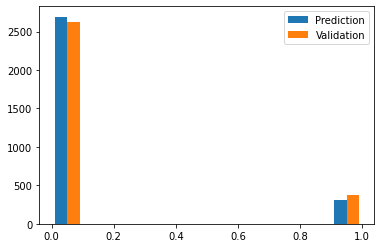

In [19]:
plt.hist(predict_df,label=predict_df.columns)
plt.legend()

In [21]:
classify.f1_score

0.20558002936857564

In [34]:
test_lend_data = lending_data.copy()
test_lend_data['annual_inc'][0:5] = pd.NA


,is_bad,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,debt_to_income,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,
1,0,10,MORTGAGE,NaN,not verified,n,medical,766xx,TX,10.87,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
2,0,1,RENT,NaN,not verified,n,debt consolidation,660xx,KS,9.15,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
3,0,4,RENT,NaN,not verified,n,credit card,916xx,CA,11.24,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
4,0,10,MORTGAGE,NaN,not verified,n,debt consolidation,124xx,NY,6.18,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
5,0,10,MORTGAGE,NaN,VERIFIED - income,n,debt consolidation,439xx,OH,19.03,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0,5,MORTGAGE,66250.0,VERIFIED - income,n,wedding,014xx,MA,9.40,...,NaN,8.0,0.0,3656,24.1,10.0,f,0.0,2,PC3
9997,0,1,RENT,26000.0,VERIFIED - income source,n,debt consolidation,112xx,NY,20.49,...,NaN,8.0,0.0,6709,58.9,12.0,f,0.0,2,PC3
9998,0,8,RENT,47831.0,not verified,n,debt consolidation,070xx,NJ,24.13,...,111.0,9.0,1.0,11346,60.7,17.0,f,0.0,3,PC3
